In [ ]:
# Importing the data

import pandas as pd

url = 'https://raw.githubusercontent.com/kboroz/TimeSeriesPredictionWS2023/main/Ch05_Sunspots_database.csv'
data = pd.read_csv(url)
data = data.iloc[:,[1,2]]

In [ ]:
# Feature engineering



# Seasonality variables
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].apply(lambda x: x.year)
data['Month'] = data['Date'].apply(lambda x: x.month)

# Adding a year of lagged data
data['L1'] = data['Monthly Mean Total Sunspot Number'].shift(1)
data['L2'] = data['Monthly Mean Total Sunspot Number'].shift(2)
data['L3'] = data['Monthly Mean Total Sunspot Number'].shift(3)
data['L4'] = data['Monthly Mean Total Sunspot Number'].shift(4)
data['L5'] = data['Monthly Mean Total Sunspot Number'].shift(5)
data['L6'] = data['Monthly Mean Total Sunspot Number'].shift(6)
data['L7'] = data['Monthly Mean Total Sunspot Number'].shift(7)
data['L8'] = data['Monthly Mean Total Sunspot Number'].shift(8)
data['L9'] = data['Monthly Mean Total Sunspot Number'].shift(9)
data['L10'] = data['Monthly Mean Total Sunspot Number'].shift(10)
data['L11'] = data['Monthly Mean Total Sunspot Number'].shift(11)
data['L12'] = data['Monthly Mean Total Sunspot Number'].shift(12)

In [ ]:
#Fitting the default Random Forest Regressor

# Create X and y object
data = data.dropna()
y = data['Monthly Mean Total Sunspot Number']
X = data[['Year', 'Month', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12']]

# Create Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=12345, shuffle=False)

from sklearn.ensemble import RandomForestRegressor
my_rf = RandomForestRegressor()
my_rf.fit(X_train, y_train)
fcst = my_rf.predict(X_test)

from sklearn.metrics import r2_score
r2_score(list(y_test), list(fcst))


0.862288234611633

In [ ]:
# Fitting the Random Forest Regressor with hyperparameter tuning

from sklearn.model_selection import GridSearchCV

my_rf = GridSearchCV(RandomForestRegressor(),
                 {'max_features':[0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
                 'n_estimators': [10, 50, 100, 250, 500, 750, 1000]},
                scoring = 'r2', n_jobs = -1)

my_rf.fit(X_train, y_train)
print(r2_score(list(y_test), list(my_rf.predict(X_test))))
print(my_rf.best_params_)

0.8682598934741633
{'max_features': 0.65, 'n_estimators': 500}


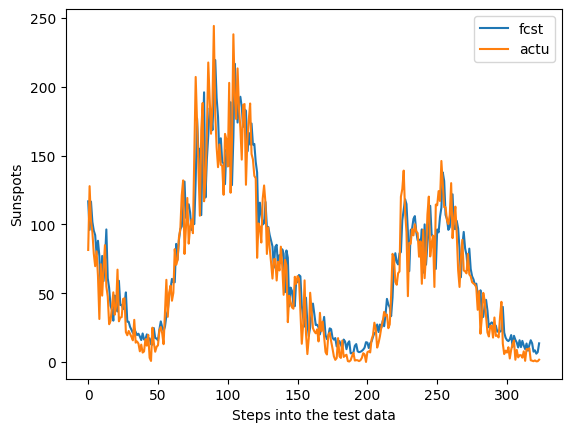

In [ ]:
# Obtaining the plot of the forecast on the test data

import matplotlib.pyplot as plt
plt.plot(list(fcst))
plt.plot(list(y_test))
plt.legend(['fcst', 'actu'])
plt.ylabel('Sunspots')
plt.xlabel('Steps into the test data')
plt.show()

## Random Search: An Alternative to Grid Search

## As a last topic , I want to introduce an alternative to grid search. This alternative is called random search. Random search is very easy to understand intuitively: rather than checking every combination of hyperparameters on the grid, it will check a random selection of hyperparameters. The main reason for this is that it is much faster. Also, it has been found that random search is generally able to obtain results that are very close to those of grid search, and the speed improvement is therefore totally worth it.

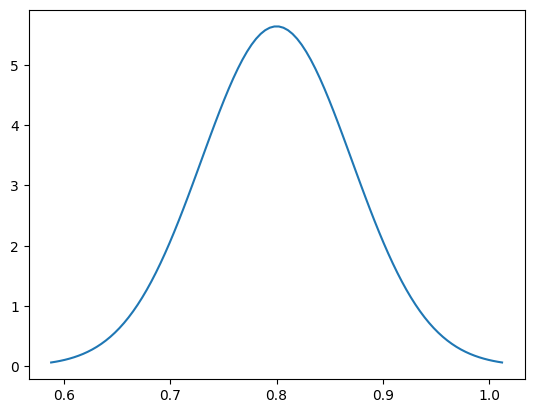

In [ ]:
# Testing out a normal distribution for the max_features

import numpy as np
import scipy.stats as stats
import math

mu = 0.8
variance = 0.005
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

## Distribution for max_features

## For the value of max_features, you previously tested values between 0.65 and 0.95 with steps of 0.05. The most used distribution is the normal distribution, so let’s see how we could use the normal distribution for this.

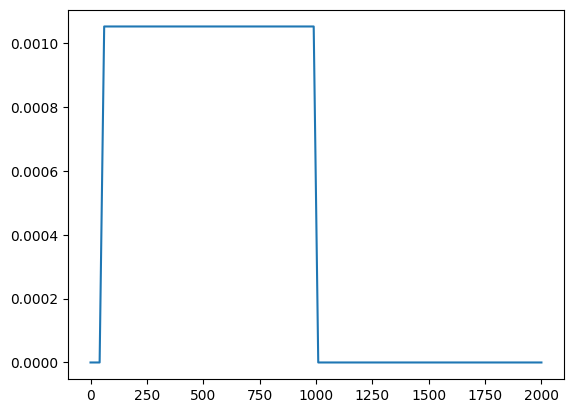

In [ ]:
# Testing out a uniform distribution for the n_estimators

x = np.linspace(0, 2000, 100)
plt.plot(x, stats.uniform.pdf(x, 50, 950))
plt.show()

In [ ]:
# RandomizedSearchCv with two distributions

from sklearn.model_selection import RandomizedSearchCV

# Specifying the distributions to draw from
distributions = {
    'max_features': stats.norm(0.8, math.sqrt(0.005)),
    'n_estimators': stats.randint(50, 1000)
}

# Creating the search
my_rf = RandomizedSearchCV(RandomForestRegressor(),

                     distributions, n_iter=10,
                          scoring = 'r2',
                          n_jobs = -1,
                          random_state = 12345)

# Fitting the search
my_rf.fit(X_train, y_train)

# Printing the results
print(r2_score(list(y_test), list(my_rf.predict(X_test))))
print(my_rf.best_params_)

0.867779042758261
{'max_features': 0.7024759740118218, 'n_estimators': 819}


## The results that you should obtain are an R2 of 0.86, and the selected hyperparameters are listed in the following. Be aware that due to randomness, you may obtain slightly different results:  

## • ‘max_features’: 0.70
## • ‘n_estimators’: 819

## The R2 is slightly lower than the one obtained by the grid search. Yet you should observe a very strong increase in execution time. The RandomizedSearchCV is much faster while only losing a very slight amount of performance: a great argument for using RandomizedSearchCV rather than GridSearchCV.

## Interpretation of Random Forests: Feature Importance

## As you have understood by now, the Random Forest is a relatively complex model. When making a prediction, it combines the predictions of many Decision Trees. This gives the model great performance, but it also makes the model relatively difficult to interpret.

## For the Decision Tree model, you have seen how you can plot the tree and follow its decisions based on a new observation. For the Random Forest, you would need to do this many times, making for a very difficult process.

## Luckily, an alternative exists for interpreting the Random Forest. This method is called feature importance. The feature importance of each variable is computed all the way throughout the fitting of the Random Forest. Every time that a variable is used for a split, the error reduction that is brought about by this split is added to the variable’s feature importance. At the end of the algorithm, those added-up errors are standardized so that the sum of the variable importance for all variables is 1.0.

## The higher the future importance of a variable, the more important the role it has played in the model and therefore the more predictive value it has for your forecast.

## Note that the Random Forest here is the one fit with RandomizedSearchCV, which is why you call best_estimator first. You also see how to combine the array of feature importances into a more accessible dataframe.


In [ ]:
# Feature Importances

fi = pd.DataFrame({
        'feature': X_train.columns,
        'importance': my_rf.best_estimator_.feature_importances_})

fi.sort_values('importance', ascending=False)

,feature,importance
2,L1,0.597124
3,L2,0.188715
4,L3,0.087132
5,L4,0.028784
6,L5,0.012928
7,L6,0.012450
10,L9,0.010181
12,L11,0.010168
9,L8,0.009550
11,L10,0.009432
